In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout
import matplotlib.pyplot as plt
import numpy as np

In [2]:
bs = 64
dataset = tf.keras.utils.image_dataset_from_directory(
    'C:/datasets',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=bs,
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='area',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
dataset = dataset.map(lambda x, y: (normalization_layer(x)))
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 928 files belonging to 1 classes.


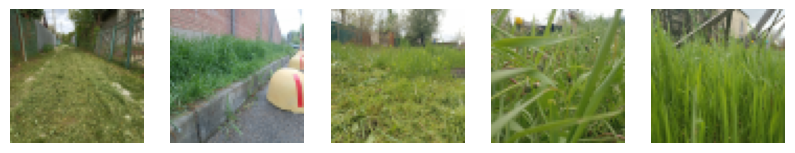

In [3]:
def imshow():    
    n = 5
    plt.figure(figsize=(10, 6))
    for images in dataset.take(1):
        for i in range(n):
            img = images[i]
            
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')
            plt.axis('off')
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow()

In [4]:
inputs = Input(shape=(128,))
x = Dense(8*8*256, use_bias=False)(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Reshape((8, 8, 256))(x)
x = Conv2DTranspose(256, 3, strides=(1, 1), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(128, 3, strides=(2, 2), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(128, 3, strides=(1, 1), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(64, 3, strides=(2, 2), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(64, 3, strides=(1, 1), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(32, 3, strides=(2, 2), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(3, 3, strides=(1, 1), padding='same', use_bias=False, activation='sigmoid')(x)
outputs = x
generator = keras.Model(inputs, outputs)

In [5]:
inputs = Input(shape=(64,64,3))
x = Conv2D(64, 3, strides=(2, 2), padding='same')(inputs)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, 3, strides=(1, 1), padding='same')(inputs)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Conv2D(128, 3, strides=(2, 2), padding='same')(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Conv2D(128, 3, strides=(2, 2), padding='same')(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Conv2D(128, 3, strides=(2, 2), padding='same')(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(64)(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation = 'sigmoid')(x)
outputs = x
discriminator= keras.Model(inputs, outputs)

In [26]:
class Model(tf.keras.Model):
    def __init__(self, gen , disc):
        super(Model, self).__init__()
        self.gen = gen
        self.disc = disc
        
        self.gen_optimizer = tf.keras.optimizers.Adam(1e-5)
        self.disc_optimizer = tf.keras.optimizers.Adam(1e-5)
        
    def gan_loss(self,logits, is_real):
        if is_real:
            labels = tf.ones_like(logits)
        else:
            labels = tf.zeros_like(logits)
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, logits)
        
        return loss
        
        
    @tf.function
    def training_step(self, x ):
        
        noise = tf.random.normal([bs, 128],0, 1, tf.float32)
        with tf.GradientTape() as disc_tape , tf.GradientTape() as gen_tape:
            
            fake_images = self.gen(noise, training=True)
            real_images = x
            
            fake_result = self.disc(fake_images, training=True)
            real_result = self.disc(real_images, training=True)
            
            disc_fake_loss = self.gan_loss(fake_result, False)
            disc_real_loss = self.gan_loss(real_result, True)
            
            disc_loss = disc_fake_loss + disc_real_loss
            
            gen_loss = self.gan_loss(fake_result, True)
 
           
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))
        
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        
        return tf.reduce_mean(disc_loss)  

In [27]:
model = Model(generator, discriminator)

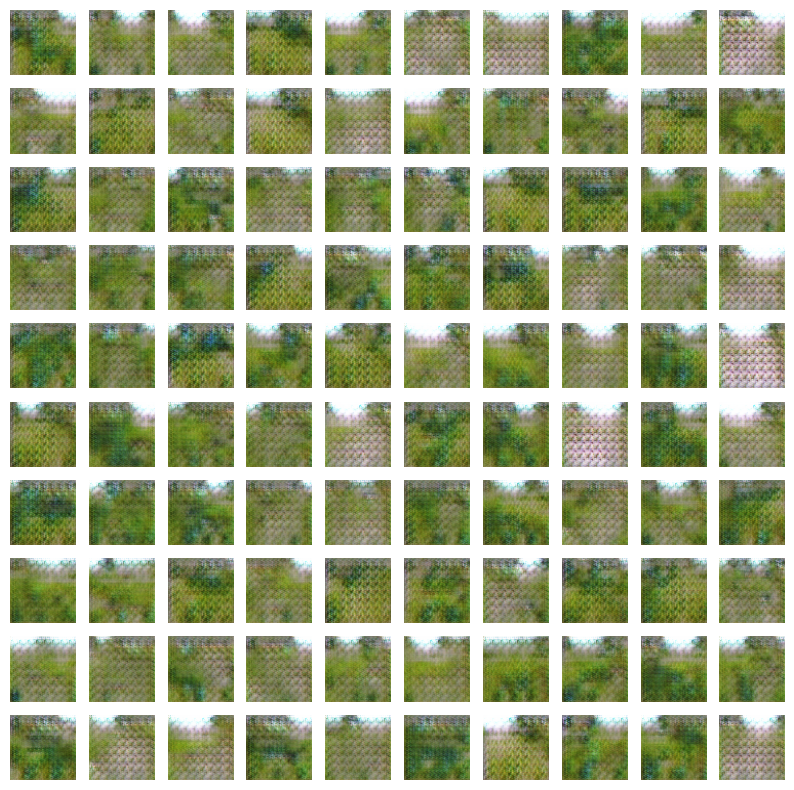

In [76]:
def generate():    
    n = 10
    plt.figure(figsize=(10, 10))
    
    for ii in dataset.take(1):
        ims = ii
    for ii in range(n):    
        for i in range(n):
            img = model.gen(tf.random.normal([1,128], 0, 1, tf.float32)) 
            img = tf.squeeze(img, axis = 0)
            ax = plt.subplot(n, n, ii*n + i+ 1)
            plt.imshow(img, cmap='gist_gray')
        #plt.title(model.disc(tf.expand_dims(img,axis = 0)).numpy()[0][0])
            plt.axis('off')
        #ax = plt.subplot(3, n, i + 1 + n)
        #plt.imshow(ims[i], cmap='gist_gray')
        #plt.title(model.disc(tf.expand_dims(ims[i],axis = 0)).numpy()[0][0])
        #ax.get_yaxis().set_visible(False) 
        #plt.axis('off')
    plt.show()
generate()

In [ ]:
epochs = 500
from IPython.display import clear_output
hist = np.array(np.empty([0]))

for epoch in range(1, epochs + 1):
    
    for step, x in enumerate(dataset):
        loss = model.training_step(x)
        if step%50 == 0:
            clear_output(wait=True)
            print(epoch)
            hist = np.append(hist, loss)
            plt.plot(np.arange(0,len(hist)), hist)
            plt.show()
            generate()
            